In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Generate synthetic dataset
np.random.seed(42)
X = np.random.rand(1000, 2) * 4 - 2  # Points in [-2, 2] x [-2, 2]
y = (X[:, 0]**2 + X[:, 1]**2 > 5).astype(np.float32)
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Training network with layer sizes: [2, 10, 1]
Epoch [10/50], Loss: 0.2190
Epoch [20/50], Loss: 0.1294
Epoch [30/50], Loss: 0.0927
Epoch [40/50], Loss: 0.0737
Epoch [50/50], Loss: 0.0642
Accuracy: 0.9890

Training network with layer sizes: [2, 50, 1]
Epoch [10/50], Loss: 0.1089
Epoch [20/50], Loss: 0.0653
Epoch [30/50], Loss: 0.0546
Epoch [40/50], Loss: 0.0450
Epoch [50/50], Loss: 0.0388
Accuracy: 0.9830

Training network with layer sizes: [2, 20, 20, 20, 1]
Epoch [10/50], Loss: 0.0843
Epoch [20/50], Loss: 0.0463
Epoch [30/50], Loss: 0.0563
Epoch [40/50], Loss: 0.0469
Epoch [50/50], Loss: 0.0321
Accuracy: 0.9900


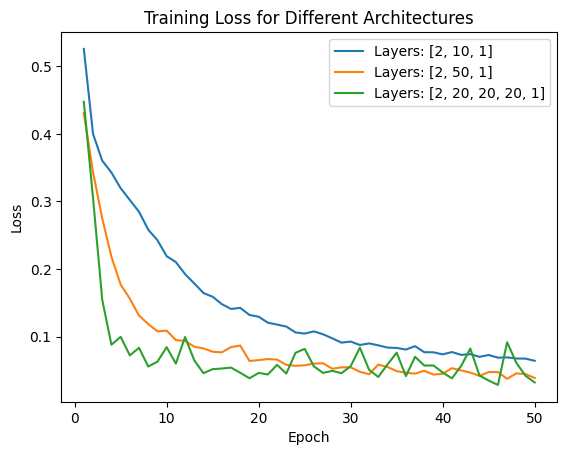

In [4]:
class FlexibleNN(nn.Module):
    def __init__(self, layer_sizes):
        super(FlexibleNN, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # No ReLU after last layer
                layers.append(nn.ReLU())
        layers.append(nn.Sigmoid())  # For binary classification
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Experiment with different depths and widths
architectures = [
    [2, 10, 1],           # Shallow: 1 hidden layer, 10 neurons
    [2, 50, 1],           # Shallow, wider: 1 hidden layer, 50 neurons
    [2, 20, 20, 20, 1],   # Deep: 3 hidden layers, 20 neurons each
]

for layer_sizes in architectures:
    print(f"\nTraining network with layer sizes: {layer_sizes}")
    model = FlexibleNN(layer_sizes)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Training loop
    num_epochs = 50
    losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Evaluate accuracy
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = (outputs >= 0.5).float()
        accuracy = (predictions == y_tensor).float().mean()
        print(f"Accuracy: {accuracy:.4f}")

    # Plot loss (for visualization, normally use Chart.js, but here we use matplotlib for simplicity)
    plt.plot(range(1, num_epochs + 1), losses, label=f"Layers: {layer_sizes}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Architectures")
plt.legend()
plt.show()